In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import yfinance as yf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

import warnings
warnings.filterwarnings('ignore')
import random

seed = 1999
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)
keras.utils.set_random_seed(seed)

2024-05-22 07:59:19.296953: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-22 07:59:19.299472: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-22 07:59:19.346518: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-22 07:59:19.347430: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-22 07:59:20.270993: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [103]:
def get_ready_data(dataname='eurusd_tech', n_past=5, val_size=252, test_size=30):
    '''
    This function imports the data given the dataname given as a parameter and will then modify the dataframe
    to something that the Machine Learning model can understand. Other parameters are avaialble:
        * n_past: how much past data should the prediction be based on.
        * validation_size: how much portion of the dataframe should the model be validated on.
        * testing_size: on how much portion of the dataframe should the model be tested on.
    
    Output:
        * scaler, X_train, y_train, X_val, y_val, X_test, y_test
    '''
    typedata = dataname.split('_')[1]

    if typedata == 'tech':
        dataframe = pd.read_csv(f'data/technical_df/{dataname}.csv').iloc[:,1:]
    elif typedata == 'macro':
        dataframe = pd.read_csv(f'data/macro_df/{dataname}.csv').iloc[:,1:]
    elif typedata == 'both':
        dataframe = pd.read_csv(f'data/both_df/{dataname}.csv').iloc[:,1:]
    else:
        raise ValueError('Check the dataname.')

    dataset = dataframe.values
    dataset = dataset.astype('float32')

    train_size = len(dataset) - (test_size + val_size)

    test_df = dataset[-test_size:]
    val_df = dataset[train_size:train_size+val_size]
    train_df = dataset[:train_size]

    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler.fit(train_df)

    train_df_scaled = scaler.fit_transform(train_df)
    val_df_scaled = scaler.fit_transform(val_df)
    test_df_scaled = scaler.fit_transform(test_df)

    def df_to_X_y(dataset, n_past=5):
        dataX, dataY = [], []
        for i in range(len(dataset)-n_past-1):
            a = dataset[i:(i+n_past), :]
            dataX.append(a)
            dataY.append(dataset[i + n_past, 0])
        return np.array(dataX), np.array(dataY)

    X_train, y_train = df_to_X_y(train_df_scaled)
    X_val, y_val = df_to_X_y(val_df_scaled)
    X_test, y_test = df_to_X_y(test_df_scaled)

    return scaler, X_train, y_train, X_val, y_val, X_test, y_test

def descaled(arr):
    '''
    This function descales the scaled data in order to have the real values.
    '''
    extended = np.zeros((len(arr), X_train.shape[2]))
    extended[:, 0] = arr
    return scaler.inverse_transform(extended)[:, 0]

def import_settings(dataname, model):
    '''
    This function imports the settings given the dataname and the model.
    '''
    typedata = dataname.split('_')[1]
    if (typedata == 'tech') & (model == 'RNN'):
        epochs, batch_size, learning_rate, units, units2, activation1, activation2, mse, rmse, mae = pd.read_csv('data/hyper_parameters/tech_rnn_df.csv', index_col=0).iloc[0,:].values
    elif (typedata == 'tech') & (model == 'LSTM'):
        epochs, batch_size, learning_rate, units, units2, activation1, activation2, mse, rmse, mae = pd.read_csv('data/hyper_parameters/tech_lstm_df.csv', index_col=0).iloc[0,:].values
    elif (typedata == 'tech') & (model == 'GRU'):
        epochs, batch_size, learning_rate, units, units2, activation1, activation2, mse, rmse, mae = pd.read_csv('data/hyper_parameters/tech_gru_df.csv', index_col=0).iloc[0,:].values
    elif (typedata == 'macro') & (model == 'RNN'):
        epochs, batch_size, learning_rate, units, units2, activation1, activation2, mse, rmse, mae = pd.read_csv('data/hyper_parameters/macro_rnn_df.csv', index_col=0).iloc[0,:].values
    elif (typedata == 'macro') & (model == 'LSTM'):
        epochs, batch_size, learning_rate, units, units2, activation1, activation2, mse, rmse, mae = pd.read_csv('data/hyper_parameters/macro_lstm_df.csv', index_col=0).iloc[0,:].values
    elif (typedata == 'macro') & (model == 'GRU'):
        epochs, batch_size, learning_rate, units, units2, activation1, activation2, mse, rmse, mae = pd.read_csv('data/hyper_parameters/macro_gru_df.csv', index_col=0).iloc[2,:].values
    elif (typedata == 'both') & (model == 'RNN'):
        epochs, batch_size, learning_rate, units, units2, activation1, activation2, mse, rmse, mae = pd.read_csv('data/hyper_parameters/both_rnn_df.csv', index_col=0).iloc[0,:].values
    elif (typedata == 'both') & (model == 'LSTM'):
        epochs, batch_size, learning_rate, units, units2, activation1, activation2, mse, rmse, mae = pd.read_csv('data/hyper_parameters/both_lstm_df.csv', index_col=0).iloc[0,:].values
    elif (typedata == 'both') & (model == 'GRU'):
        epochs, batch_size, learning_rate, units, units2, activation1, activation2, mse, rmse, mae = pd.read_csv('data/hyper_parameters/both_gru_df.csv', index_col=0).iloc[1,:].values
    else:
        raise ValueError('Check the dataname or the model name.')
    
    return epochs, batch_size, learning_rate, units, units2, activation1, activation2, mse, rmse, mae

In [6]:
def plot_loss_and_prices(typedata, history, y_actual, y_pred, model, units1, units2, epochs, batch_size, learning_rate, activation1, activation2, mse, rmse, mae):
    '''
    This function plots the Training and Validation Loss along with Predicted vs Actual Price
    '''
    # Get training and validation loss from history
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    if history.epoch[-1]+1 != epochs:
        epochs = f'{history.epoch[-1]+1} (early stop)'
    
    if typedata == 'tech':
        typedata = 'Technical Indicators'
    elif typedata == 'macro':
        typedata = 'Macroeconomic Indicators'
    elif typedata == 'both':
        typedata = 'Both Indicators'
    else:
        raise ValueError('Check your dataname.')

    mse = np.round(float(mse),6)
    rmse = np.round(rmse, 6)
    mae = np.round(mae, 6)
    
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    plt.suptitle(f'{model} - {typedata} - Epochs: {epochs} - Batch size: {batch_size} - Learning rate: {learning_rate}\n Layer 1: {units1} hidden units - Activation function: {activation1}\n Layer 2: {units2} hidden units - Activation function: {activation2}\n RMSE: {rmse} - MAE: {mae}',
    fontsize=18)

    ax1.plot(train_loss, label='Training Loss')
    ax1.plot(val_loss, label='Validation Loss')
    ax1.set_title('Training and Validation Loss', fontsize=16)
    ax1.set_xlabel('Epoch', fontsize=16)
    ax1.set_ylabel('Loss', fontsize=16)
    ax1.set_ylim(0, 0.2)
    ax1.tick_params(axis='both', which='major', labelsize=14)
    ax1.legend()

    ax2.plot(y_actual, label='Actual Prices')
    ax2.plot(y_pred, label='Predicted Prices')
    ax2.set_title(f'Actual vs Predicted Prices - Testing', fontsize=16)
    ax2.set_xlabel('Time', fontsize=16)
    ax2.set_ylabel('Price ($)', fontsize=16)
    ax2.tick_params(axis='both', which='major', labelsize=14)
    ax2.legend()

    # Adjust layout
    plt.tight_layout()

    # Show the plot
    plt.show()

In [7]:
def RNN_model(dataname='eurusd_tech'):
    '''
    This function creates a RNN model given a dataname. Given the dataname, we will get the ready-to-use data and the parameters.
    '''
    model = 'RNN'
    typedata = dataname.split('_')[1]
    
    scaler, X_train, y_train, X_val, y_val, X_test, y_test = get_ready_data(dataname)

    epochs, batch_size, learning_rate, units1, units2, activation1, activation2, mse, rmse, mae = import_settings(dataname, model)
    model_rnn = Sequential()
    model_rnn.add(SimpleRNN(units1, activation=activation1, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model_rnn.add(SimpleRNN(units2, activation=activation2, return_sequences=False))
    model_rnn.add(Dense(1))
    optimizer = Adam(learning_rate=learning_rate)
    model_rnn.compile(optimizer=optimizer, loss='mean_squared_error')

    history_rnn = model_rnn.fit(
    X_train,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_val, y_val),
    verbose=0)

    model_rnn.save(f'models-checkpoints/rnn-{dataname.split("_")[1]}-{dataname.split("_")[0]}.h5')

    y_pred_rnn = model_rnn.predict(X_test)
    y_pred_rnn = np.delete(descaled(y_pred_rnn.flatten()),0)
    y_test = np.delete(descaled(y_test),-1)

    # Plot training and validation loss
    plot_loss_and_prices(typedata, history_rnn, y_test, y_pred_rnn, model, units1, units2, epochs, batch_size, learning_rate, activation1, activation2, mse, rmse, mae)

    return model_rnn, y_test, y_pred_rnn

def LSTM_model(dataname='eurusd_tech'):
    '''
    This function creates a LSTM model given a dataname. Given the dataname, we will get the ready-to-use data and the parameters.
    '''
    model = 'LSTM'
    typedata = dataname.split('_')[1]
    
    scaler, X_train, y_train, X_val, y_val, X_test, y_test = get_ready_data(dataname)

    epochs, batch_size, learning_rate, units1, units2, activation1, activation2, mse, rmse, mae = import_settings(dataname, model)
    model_lstm = Sequential()
    model_lstm.add(LSTM(units1, activation=activation1, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model_lstm.add(LSTM(units2, activation=activation2, return_sequences=False))
    model_lstm.add(Dense(1))
    optimizer = Adam(learning_rate=learning_rate)
    model_lstm.compile(optimizer=optimizer, loss='mean_squared_error')

    history_lstm = model_lstm.fit(
    X_train,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_val, y_val),
    verbose=0)

    model_lstm.save(f'models-checkpoints/lstm-{dataname.split("_")[1]}-{dataname.split("_")[0]}.h5')

    y_pred_lstm = model_lstm.predict(X_test)
    y_pred_lstm = np.delete(descaled(y_pred_lstm.flatten()),0)
    y_test = np.delete(descaled(y_test),-1)

    # Plot training and validation loss

    plot_loss_and_prices(typedata, history_lstm, y_test, y_pred_lstm, model, units1, units2, epochs, batch_size, learning_rate, activation1, activation2, mse, rmse, mae)

    return model_lstm, y_test, y_pred_lstm

def GRU_model(dataname='eurusd_tech'):
    '''
    This function creates a GRU model given a dataname. Given the dataname, we will get the ready-to-use data and the parameters.
    '''
    model = 'GRU'
    typedata = dataname.split('_')[1]

    scaler, X_train, y_train, X_val, y_val, X_test, y_test = get_ready_data(dataname)

    epochs, batch_size, learning_rate, units1, units2, activation1, activation2, mse, rmse, mae = import_settings(dataname, model)
    model_gru = Sequential()
    model_gru.add(GRU(units1, activation=activation1, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model_gru.add(GRU(units2, activation=activation2, return_sequences=False))
    model_gru.add(Dense(1))
    optimizer = Adam(learning_rate=learning_rate)
    model_gru.compile(optimizer=optimizer, loss='mean_squared_error')

    history_gru = model_gru.fit(
    X_train,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_val, y_val),
    verbose=0)

    model_gru.save(f'models-checkpoints/gru-{dataname.split("_")[1]}-{dataname.split("_")[0]}.h5')

    y_pred_gru = model_gru.predict(X_test)
    y_pred_gru = np.delete(descaled(y_pred_gru.flatten()),0)
    y_test = np.delete(descaled(y_test),-1)

    # Plot training and validation loss
    plot_loss_and_prices(typedata, history_gru, y_test, y_pred_gru, model, units1, units2, epochs, batch_size, learning_rate, activation1, activation2, mse, rmse, mae)

    return model_gru, y_test, y_pred_gru

In [128]:
def other_currencies(dataname, model, modelname):
    scaler, X_train, y_train, X_val, y_val, X_test, y_test = get_ready_data(dataname)
    y_pred_model = model.predict(X_test)
    y_pred_model = np.delete(descaled(y_pred_model.flatten()),0)
    y_test = np.delete(descaled(y_test),-1)

    mse = mean_squared_error(y_test, y_pred_model)
    rmse = np.round(np.sqrt(mse),6)
    mae = np.round(mean_absolute_error(y_test, y_pred_model),6)

    plt.figure(figsize=(6, 4))
    plt.plot(y_test, label='Actual Prices')
    plt.plot(y_pred_model, label='Predicted Prices')
    plt.title(f'Actual vs Predicted Prices - {modelname} - {dataname}\n RMSE: {rmse} - MAE: {mae} ', fontsize=16)
    plt.xlabel('Time', fontsize=16)  # Correct method usage
    plt.ylabel('Price ($)', fontsize=16)  # Correct method usage
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.legend()
    plt.tight_layout()
    plt.show()
    

### Part I: Recurrent Neural Network (RNN)
#### Technical Indicators

1/1 [==============================] - 0s 201ms/step


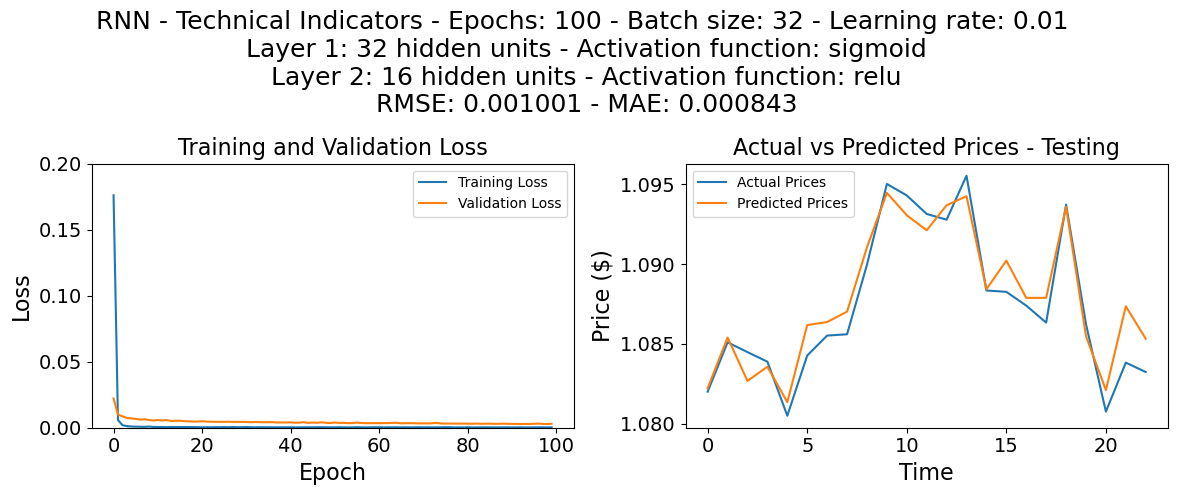

In [54]:
dataname = 'eurusd_tech'
scaler, X_train, y_train, X_val, y_val, X_test, y_test = get_ready_data(dataname=dataname)
model_rnn_tech, y_test, y_pred_rnn_tech = RNN_model(dataname=dataname)


1/1 [==============================] - 0s 25ms/step


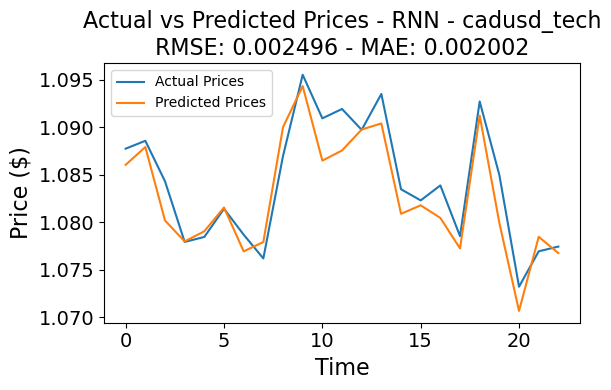

1/1 [==============================] - 0s 19ms/step


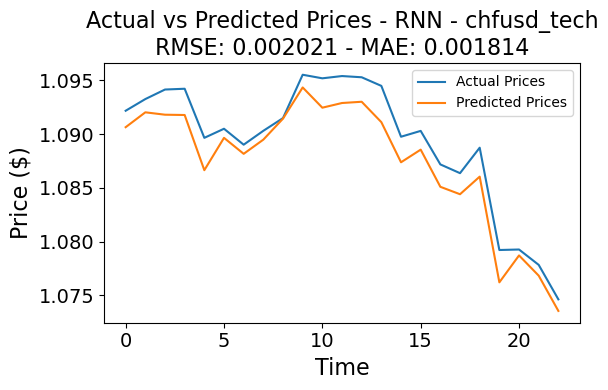

1/1 [==============================] - 0s 26ms/step


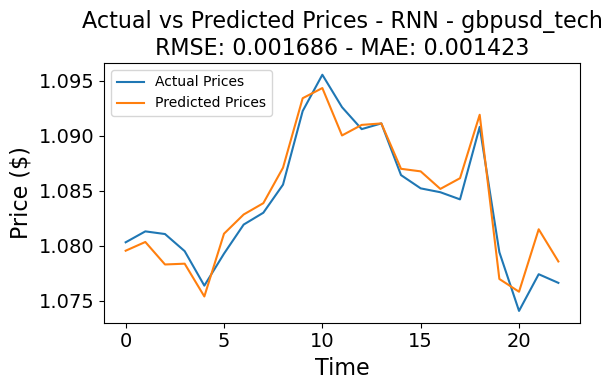

In [129]:
datalists = ['cadusd_tech', 'chfusd_tech', 'gbpusd_tech']
model = 'RNN'

for dataname in datalists:
    other_currencies(dataname, model_rnn_tech, model)

#### Macroeconomic Indicators

1/1 [==============================] - 0s 200ms/step


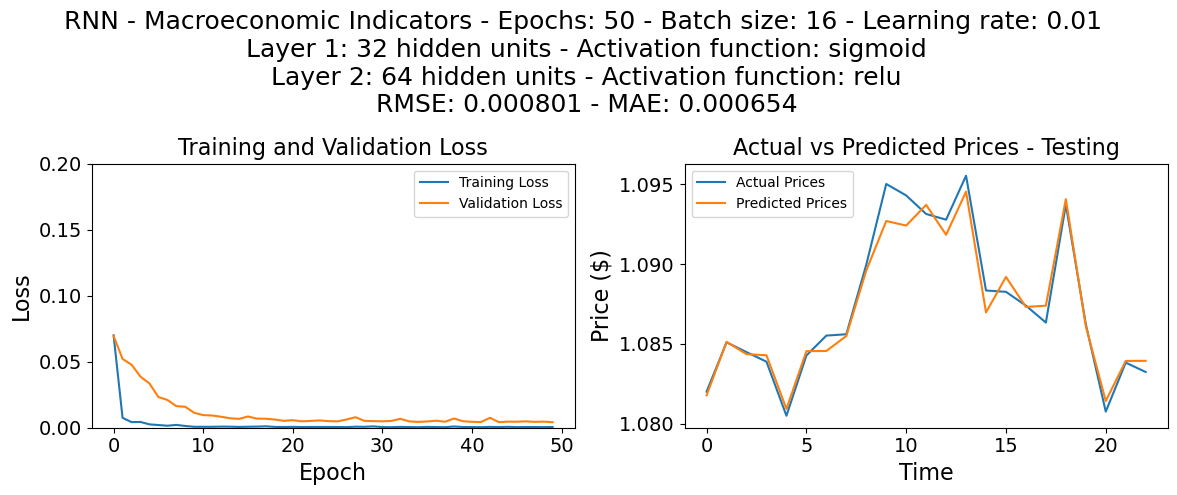

In [58]:
dataname = 'eurusd_macro'
scaler, X_train, y_train, X_val, y_val, X_test, y_test = get_ready_data(dataname=dataname)
model_rnn_macro, y_test, y_pred_rnn_macro = RNN_model(dataname=dataname)

#### Technical + Macroeconomic Indicators

1/1 [==============================] - 0s 183ms/step


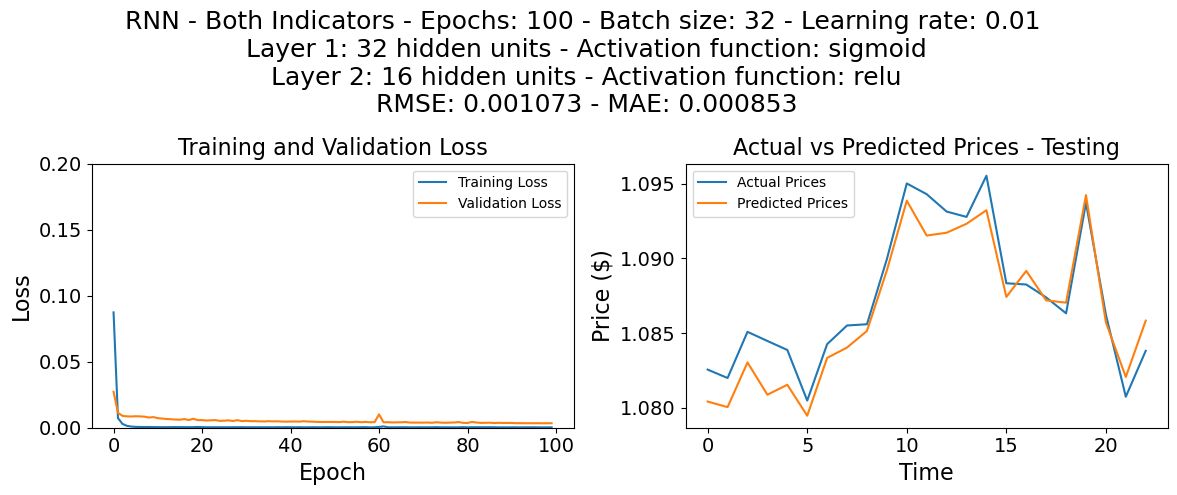

In [41]:
dataname = 'eurusd_both'
scaler, X_train, y_train, X_val, y_val, X_test, y_test = get_ready_data(dataname=dataname)
model_rnn_both, y_test, y_pred_rnn_both = RNN_model(dataname=dataname)

### Long Short-Term Memory (LSTM)
#### Technical Indicators

2024-05-22 08:43:09.704053: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-22 08:43:09.705794: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-22 08:43:09.706991: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 0s 436ms/step


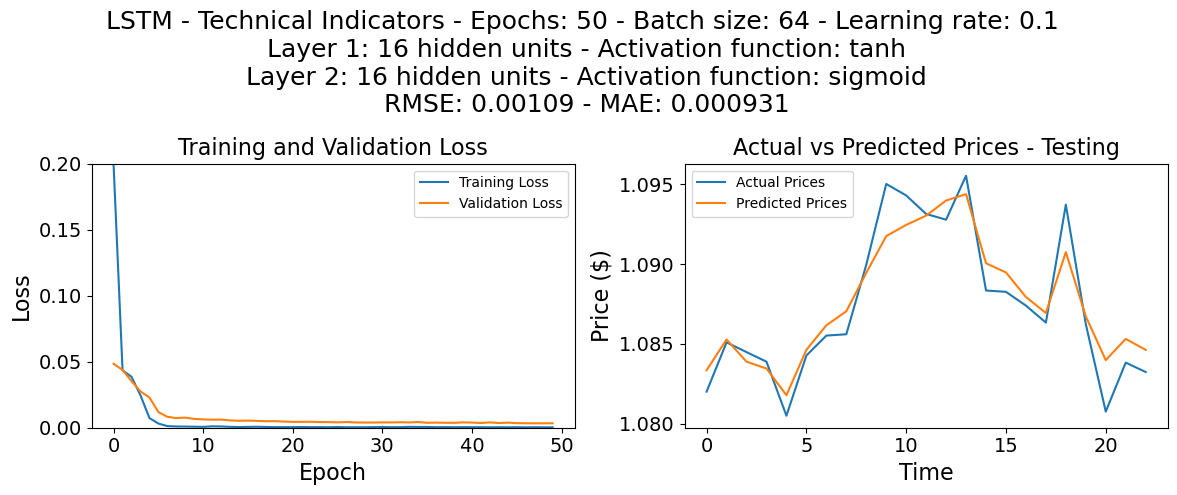

In [61]:
dataname = 'eurusd_tech'
scaler, X_train, y_train, X_val, y_val, X_test, y_test = get_ready_data(dataname=dataname)
model_lstm_tech, y_test, y_pred_lstm_tech = LSTM_model(dataname=dataname)

1/1 [==============================] - 0s 22ms/step


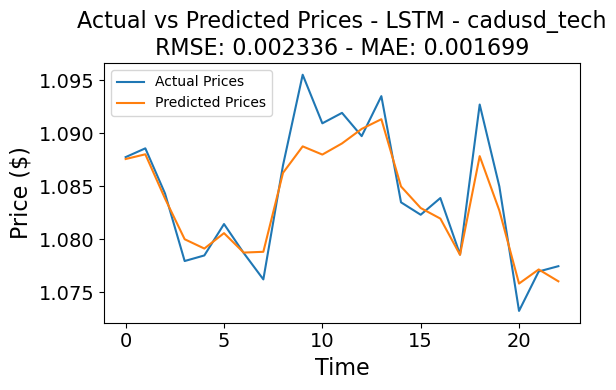

1/1 [==============================] - 0s 20ms/step


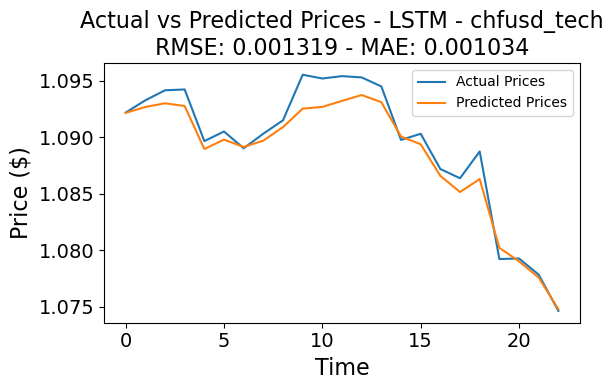

1/1 [==============================] - 0s 22ms/step


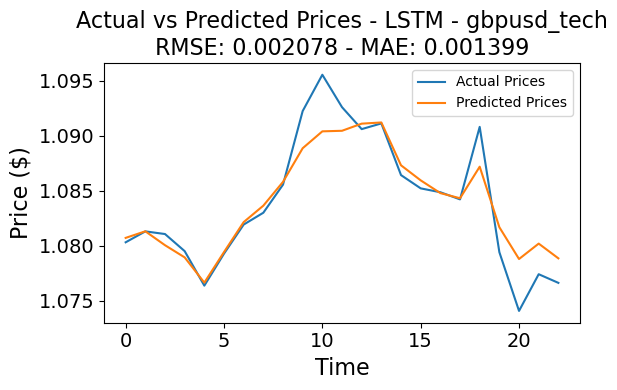

In [130]:
datalists = ['cadusd_tech', 'chfusd_tech', 'gbpusd_tech']
model = 'LSTM'

for dataname in datalists:
    other_currencies(dataname, model_lstm_tech, model)

#### Macroeconomic Indicators

2024-05-22 09:31:40.111833: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-22 09:31:40.113133: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-22 09:31:40.114439: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 0s 392ms/step


2024-05-22 09:31:56.793578: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-22 09:31:56.794909: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-22 09:31:56.796281: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

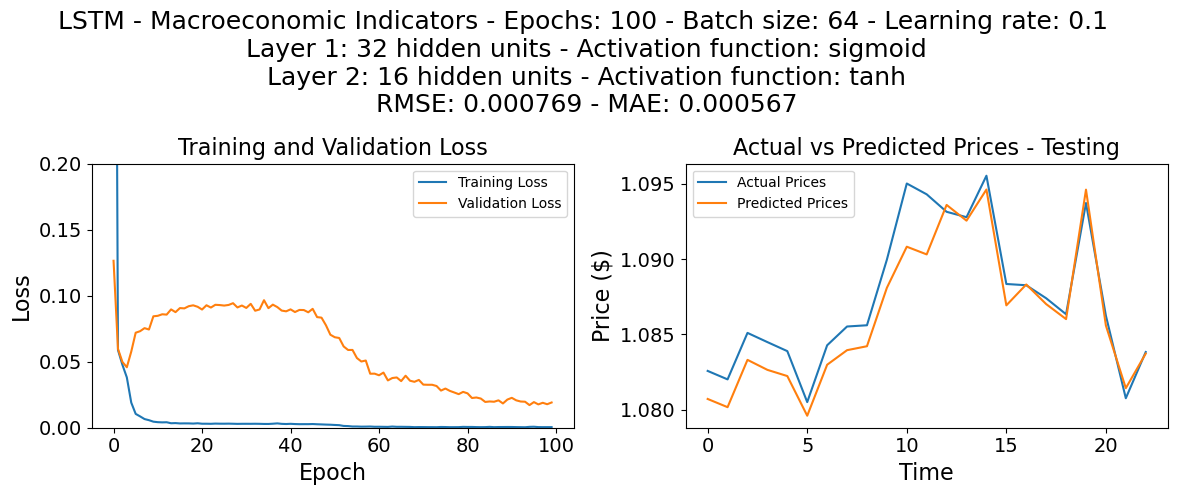

In [90]:
dataname = 'eurusd_macro'
scaler, X_train, y_train, X_val, y_val, X_test, y_test = get_ready_data(dataname=dataname)
model_lstm_macro, y_test, y_pred_lstm_macro = LSTM_model(dataname=dataname)

#### Technical + Macroeconomic Indicators

1/1 [==============================] - 0s 229ms/step


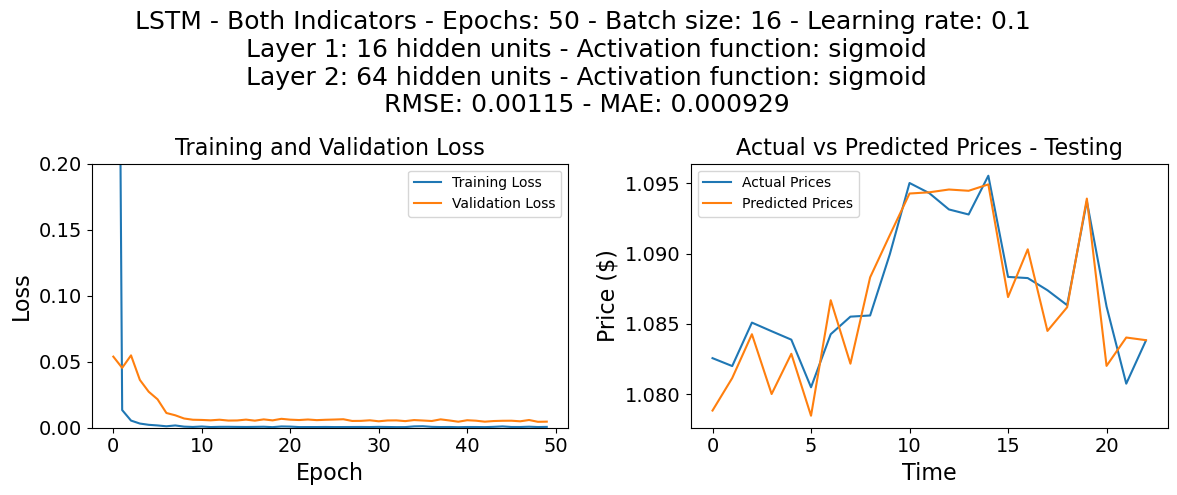

In [91]:
dataname = 'eurusd_both'
scaler, X_train, y_train, X_val, y_val, X_test, y_test = get_ready_data(dataname=dataname)
model_lstm_both, y_test, y_pred_lstm_both = LSTM_model(dataname=dataname)

### Gated Recurrent Unit (GRU)
#### Technical Indicators

2024-05-22 09:33:02.777823: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-22 09:33:02.779540: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-22 09:33:02.780682: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 0s 405ms/step


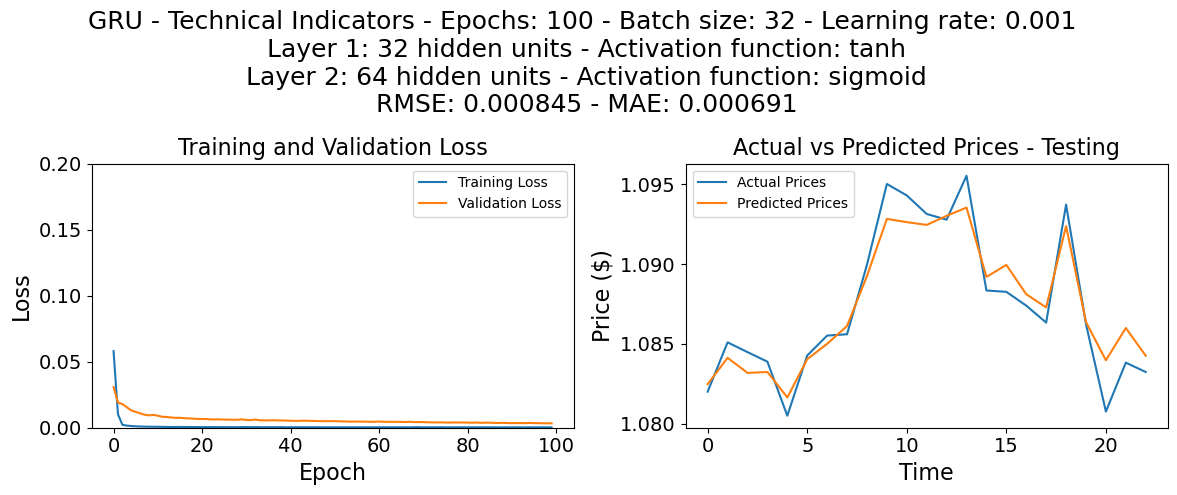

In [92]:
dataname = 'eurusd_tech'
scaler, X_train, y_train, X_val, y_val, X_test, y_test = get_ready_data(dataname=dataname)
model_gru_tech, y_test, y_pred_gru_tech = GRU_model(dataname=dataname)

1/1 [==============================] - 0s 23ms/step


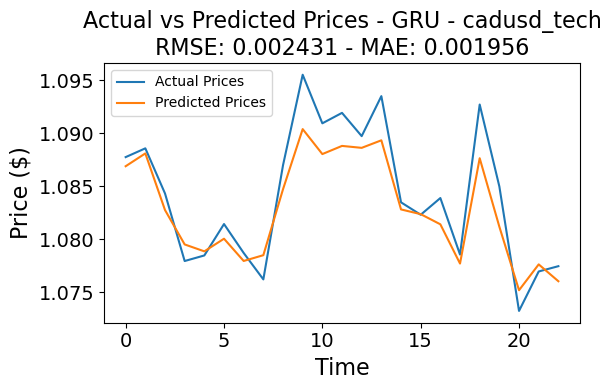

1/1 [==============================] - 0s 31ms/step


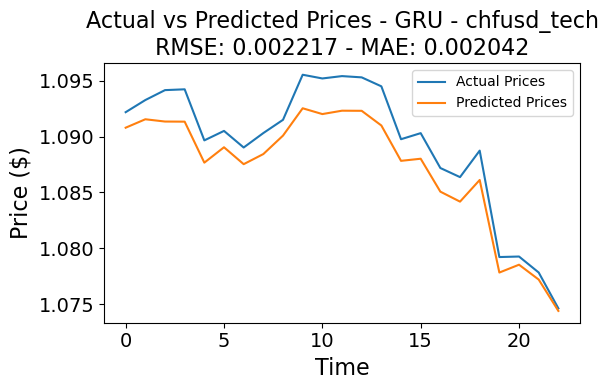

1/1 [==============================] - 0s 20ms/step


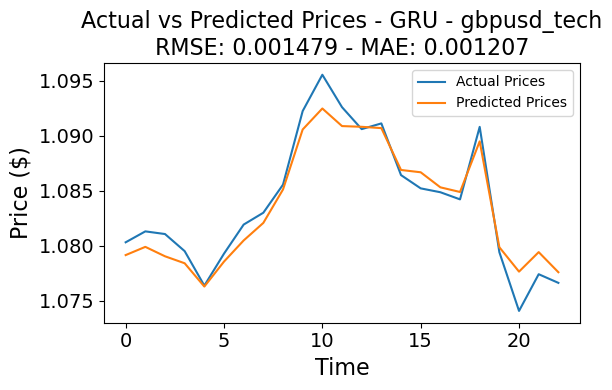

In [131]:
datalists = ['cadusd_tech', 'chfusd_tech', 'gbpusd_tech']
model = 'GRU'

for dataname in datalists:
    other_currencies(dataname, model_gru_tech, model)

#### Macroeconomic Indicators

1/1 [==============================] - 0s 228ms/step


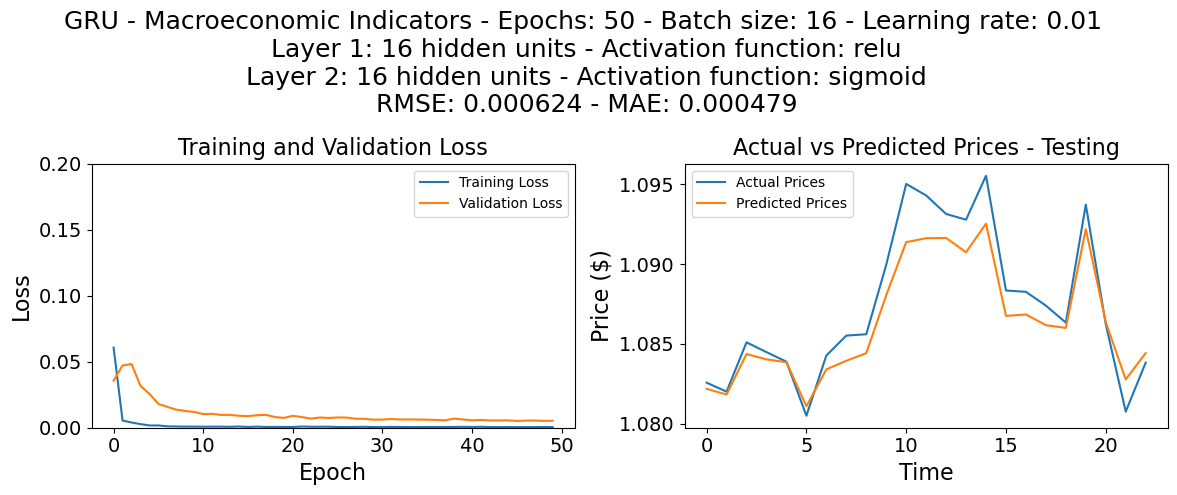

In [97]:
dataname = 'eurusd_macro'
scaler, X_train, y_train, X_val, y_val, X_test, y_test = get_ready_data(dataname=dataname)
model_gru_macro, y_test, y_pred_gru_macro = GRU_model(dataname=dataname)

#### Technical + Macroeconomic Indicators

1/1 [==============================] - 0s 268ms/step


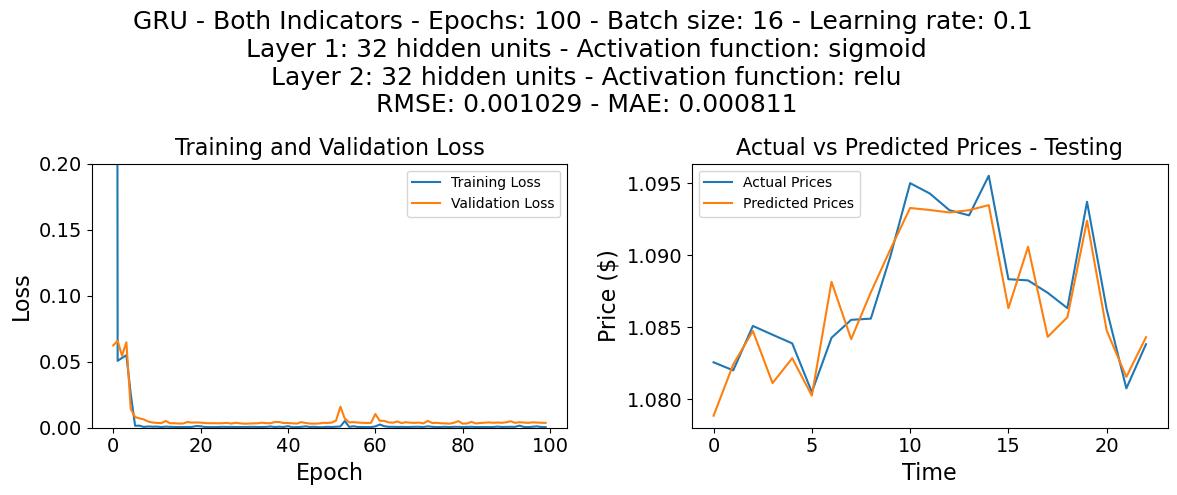

In [104]:
dataname = 'eurusd_both'
scaler, X_train, y_train, X_val, y_val, X_test, y_test = get_ready_data(dataname=dataname)
model_gru_both, y_test, y_pred_gru_both = GRU_model(dataname=dataname)

In [111]:
data = {
    'y_test': y_test,
    'y_pred_rnn_tech': y_pred_rnn_tech,
    'y_pred_rnn_macro': y_pred_rnn_macro,
    'y_pred_rnn_both': y_pred_rnn_both,
    'y_pred_lstm_tech': y_pred_lstm_tech,
    'y_pred_lstm_macro': y_pred_lstm_macro,
    'y_pred_lstm_both': y_pred_lstm_both,
    'y_pred_gru_tech': y_pred_gru_tech,
    'y_pred_gru_macro': y_pred_gru_macro,
    'y_pred_gru_both': y_pred_gru_both
}

df = pd.DataFrame(data)
df

,y_test,y_pred_rnn_tech,y_pred_rnn_macro,y_pred_rnn_both,y_pred_lstm_tech,y_pred_lstm_macro,y_pred_lstm_both,y_pred_gru_tech,y_pred_gru_macro,y_pred_gru_both
0,1.082567,1.082217,1.081776,1.080431,1.083350,1.080705,1.078843,1.082474,1.082179,1.078854
1,1.082005,1.085394,1.085126,1.080058,1.085274,1.080160,1.081153,1.084125,1.081826,1.082416
2,1.085093,1.082676,1.084353,1.083047,1.083880,1.083302,1.084268,1.083180,1.084359,1.084744
3,1.084481,1.083569,1.084284,1.080888,1.083454,1.082638,1.080018,1.083236,1.084026,1.081123
4,1.083882,1.081346,1.080917,1.081554,1.081780,1.082226,1.082879,1.081641,1.083850,1.082852
5,1.080497,1.086176,1.084539,1.079483,1.084624,1.079592,1.078476,1.084039,1.081093,1.080248
6,1.084269,1.086367,1.084553,1.083349,1.086161,1.082978,1.086684,1.084998,1.083400,1.088157
7,1.085517,1.087017,1.085490,1.084043,1.087039,1.083945,1.082173,1.086118,1.083939,1.084177
8,1.085600,1.091043,1.089595,1.085152,1.089447,1.084208,1.088309,1.089246,1.084416,1.087423
9,1.089954,1.094459,1.092694,1.089204,1.091746,1.088086,1.091313,1.092828,1.088043,1.090431


In [118]:
# Calculate the difference between consecutive rows for each column
price_diff = df.diff()

# Create a new DataFrame indicating whether each column has increased or decreased
price_change_df = pd.DataFrame(index=df.index)

# Apply the logic to each element of the DataFrame
price_change_df = price_diff.applymap(lambda x: 'Increased' if x > 0 else 'Decreased' if x < 0 else 'No Change')

# Rename the index column
price_change_df.index.name = 'Index'
price_change_df = price_change_df.drop(price_change_df.index[0])

price_change_df

,y_test,y_pred_rnn_tech,y_pred_rnn_macro,y_pred_rnn_both,y_pred_lstm_tech,y_pred_lstm_macro,y_pred_lstm_both,y_pred_gru_tech,y_pred_gru_macro,y_pred_gru_both
Index,,,,,,,,,,
1,Decreased,Increased,Increased,Decreased,Increased,Decreased,Increased,Increased,Decreased,Increased
2,Increased,Decreased,Decreased,Increased,Decreased,Increased,Increased,Decreased,Increased,Increased
3,Decreased,Increased,Decreased,Decreased,Decreased,Decreased,Decreased,Increased,Decreased,Decreased
4,Decreased,Decreased,Decreased,Increased,Decreased,Decreased,Increased,Decreased,Decreased,Increased
5,Decreased,Increased,Increased,Decreased,Increased,Decreased,Decreased,Increased,Decreased,Decreased
6,Increased,Increased,Increased,Increased,Increased,Increased,Increased,Increased,Increased,Increased
7,Increased,Increased,Increased,Increased,Increased,Increased,Decreased,Increased,Increased,Decreased
8,Increased,Increased,Increased,Increased,Increased,Increased,Increased,Increased,Increased,Increased
9,Increased,Increased,Increased,Increased,Increased,Increased,Increased,Increased,Increased,Increased


In [126]:
comparison_df = pd.DataFrame(index=price_change_df.index)

# Iterate over columns from the second column onwards
for col in price_change_df.columns[1:]:
    # Compare each column with the first column (y_test)
    comparison_df[col] = (price_change_df[col] == price_change_df['y_test']).astype(int)

# Display the result
comparison_df.sum() / price_change_df.shape[0]

y_pred_rnn_tech      0.363636
y_pred_rnn_macro     0.454545
y_pred_rnn_both      0.818182
y_pred_lstm_tech     0.500000
y_pred_lstm_macro    0.909091
y_pred_lstm_both     0.590909
y_pred_gru_tech      0.409091
y_pred_gru_macro     0.863636
y_pred_gru_both      0.727273
dtype: float64